## Stage - E Quiz

In this quiz, we’ll explore and build time series forecasting models for measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years.

Data Set Information:

Data Link: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

This archive contains 2075259 measurements gathered between December 2006 and November 2010 (47 months).

Notes:

1. (globalactivepower*1000/60 - submetering1 - submetering2 - submetering3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

2. The dataset contains some missing values in the measurements (nearly 1.25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

Attribute Information:

1. date: Date in format dd/mm/yyyy
2. time: time in format hh:mm:ss
3. globalactivepower: household global minute-averaged active power (in kilowatt)
4. globalreactivepower: household global minute-averaged reactive power (in kilowatt)
5. voltage: minute-averaged voltage (in volt)
6. global_intensity: household global minute-averaged current intensity (in ampere)
7. submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8. submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9. submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

# Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from prophet import Prophet
from scipy.stats import pearsonr

In [2]:
#loading the dataset
df = pd.read_csv('./Downloads/household_power_consumption.txt', sep = ';',
                 na_values = '?', dtype = float, low_memory = False, infer_datetime_format = True,
                 parse_dates = {'datetime':[0,1]}, index_col = ['datetime'])

In [3]:
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [4]:
print(df.shape)
df.isnull().sum()

(2075259, 7)


Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

### Q11
Firstly, forward-fill all the missing values. Resample the data from a minute sampling rate to an hourly sampling rate (i.e sum over the minutes for each hour). Which of the following is a plot of the hourly global_active_power over time?

In [5]:
df.fillna(method='ffill', inplace=True)

In [6]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

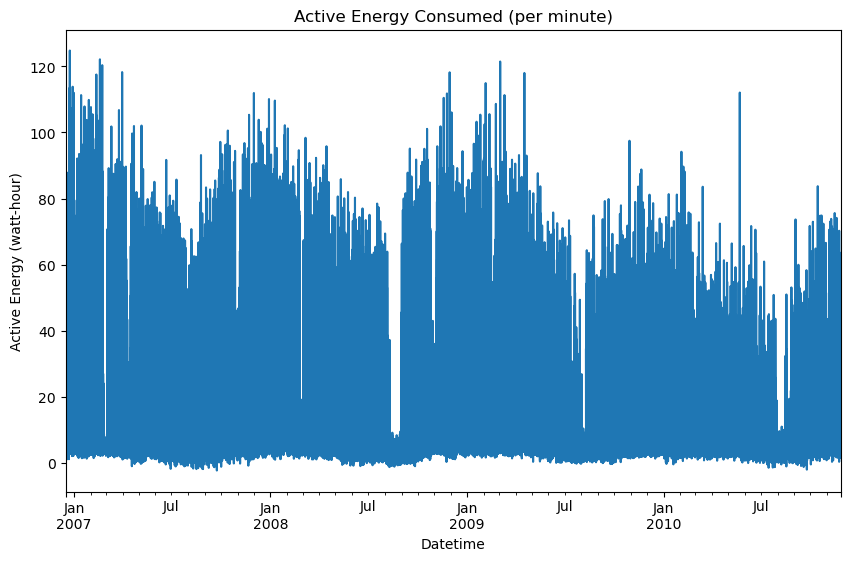

In [7]:
df['Active Energy Consumed (per minute)'] = (df['Global_active_power']*1000/60) - df['Sub_metering_1'] - df['Sub_metering_2'] - df['Sub_metering_3']

# Plot the unmeasured energy to visualize
plt.figure(figsize=(10, 6))
df['Active Energy Consumed (per minute)'].plot()
plt.title('Active Energy Consumed (per minute)')
plt.xlabel('Datetime')
plt.ylabel('Active Energy (watt-hour)')
plt.show()

### Q12
What is the Pearson correlation coefficient between the global_active_power and voltage? To 3 decimal places

In [8]:
pearsonr(df['Global_active_power'], df['Voltage'])

(-0.39564658423499605, 0.0)

### Q13
What is the Pearson correlation coefficient between the Voltage and global_intensity? To 2 decimal places.

In [9]:
pearsonr(df['Voltage'], df['Global_intensity'])

(-0.4074536992188633, 0.0)

Using the daily sampling rate (sum), divide the data into a train and test set. The last 300 days is your test set and the first (x-300) days is your training set. Where x is the length of the dataset. Use Facebook Prophet to train a Univariate time series modeling using this time column (‘dt’ or ‘ds’) and the global_active_power (or ‘y’). Answer questions 14 - 16:

In [10]:
# Resample the data to daily frequency, summing the values
df_daily = df.resample('D').sum()

# Create the target variable 'y' and the time variable 'ds'
df_daily.reset_index(inplace=True)
df_daily.rename(columns={'datetime': 'ds', 'Global_active_power': 'y'}, inplace=True)

In [11]:
# Split the data into train and test sets
train_size = len(df_daily) - 300
train_df = df_daily.iloc[:train_size]
test_df = df_daily.iloc[train_size:]

In [12]:
# Initialize and train the Prophet model
model = Prophet()
model.fit(train_df)

# Make predictions
future = model.make_future_dataframe(periods=300)
forecast = model.predict(future)

19:31:20 - cmdstanpy - INFO - Chain [1] start processing
19:31:20 - cmdstanpy - INFO - Chain [1] done processing


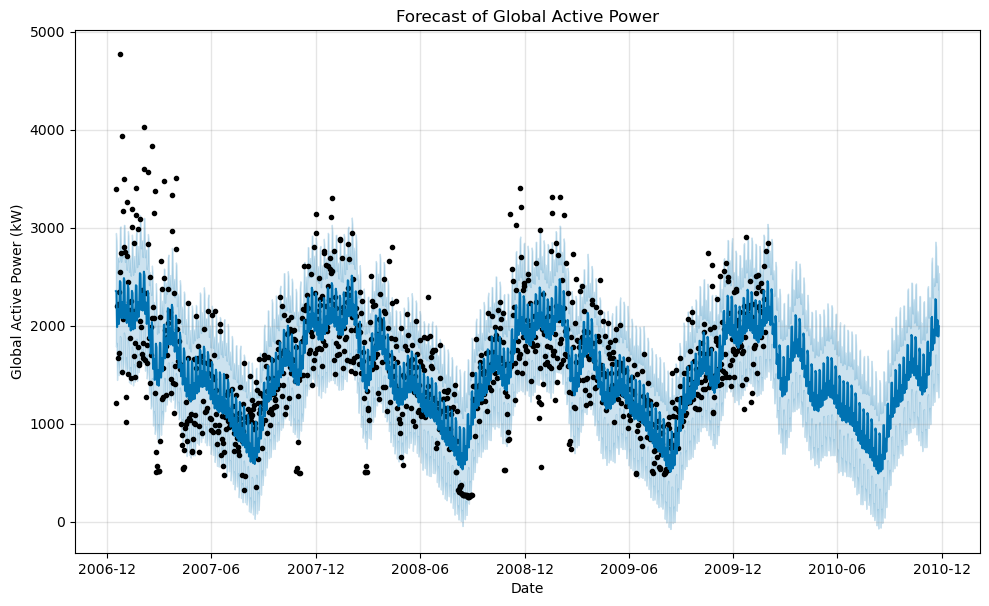

In [13]:
# Plot the forecast
fig = model.plot(forecast)
plt.title('Forecast of Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.show()

In [14]:
# Evaluate the model on the test set
forecast_test = forecast.iloc[-300:][['ds', 'yhat']]
forecast_test = forecast_test.set_index('ds')
test_df.set_index('ds', inplace=True)

### Q14
Evaluating the results of your time series modeling on the test set. What is the MAPE (in %) in 2 decimal places?

### Q15
What is the RMSE in 2 decimal places?

In [15]:
# Calculate evaluation metric
mae = mean_absolute_error(test_df['y'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(test_df['y'], forecast_test['yhat']))
mape = mean_absolute_percentage_error(test_df['y'], forecast_test['yhat'])

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute  Percentage Error (MAE): {mape*100:.2f}')

Mean Absolute Error (MAE): 295.4935713215702
Root Mean Squared Error (RMSE): 401.70
Mean Absolute  Percentage Error (MAE): 27.20


### Q16
If you plot the components from the forecasted model, what day of the weekly seasonality has the lowest value?

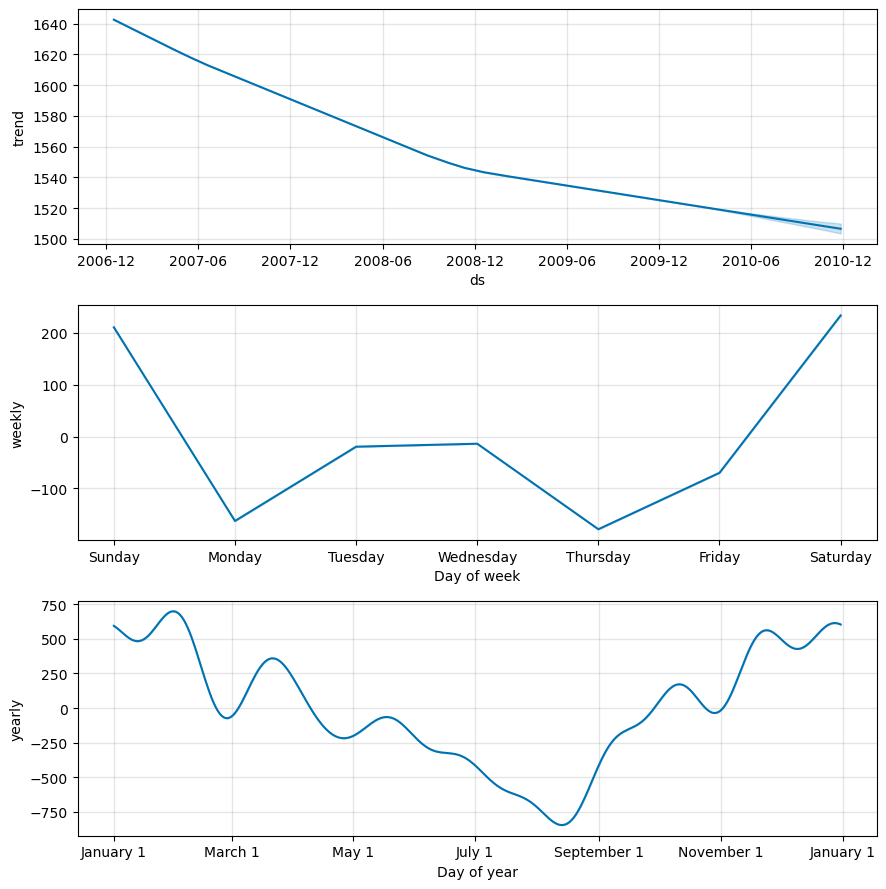

In [16]:
model.plot_components(forecast)
plt.show()


Multivariate Time Series Forecasting with Facebook Prophet

In the last exercise, we used only the dependent variable (Global_Active_Power) and the time component for our modeling (ds vs y). Next, we will build a time series model using the other variables. These variables will be added to the forecast model as a regressor on Facebook Prophet. So the six independent variables ['Global_reactive_power', 'Voltage','Global_intensity', 'Sub_metering_1','Sub_metering_2','Sub_metering_3'] will be [‘add1’, ‘add2’, ‘add3’, ‘add4’, ‘add5’, ‘add6’] as the regressors. Split the data into train and test as done above and build a multivariate forecast model to forecast the last 300 days of the house consumption (‘global_active_power’). Answer questions 17-20:

In [17]:
# Rename other columns to be used as regressors
df_daily.rename(columns={
    'Global_reactive_power': 'add1',
    'Voltage': 'add2',
    'Global_intensity': 'add3',
    'Sub_metering_1': 'add4',
    'Sub_metering_2': 'add5',
    'Sub_metering_3': 'add6'
}, inplace=True)

In [18]:
# Split the data into train and test sets
train_size = len(df_daily) - 300
train_df = df_daily.iloc[:train_size]
test_df = df_daily.iloc[train_size:]

In [19]:
# Initialize and train the Prophet model with regressors
model = Prophet()
model.add_regressor('add1')
model.add_regressor('add2')
model.add_regressor('add3')
model.add_regressor('add4')
model.add_regressor('add5')
model.add_regressor('add6')
model.fit(train_df)

19:31:23 - cmdstanpy - INFO - Chain [1] start processing
19:31:24 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
# Make predictions
future = model.make_future_dataframe(periods=300)
# Add the regressors to the future dataframe
future['add1'] = df_daily['add1']
future['add2'] = df_daily['add2']
future['add3'] = df_daily['add3']
future['add4'] = df_daily['add4']
future['add5'] = df_daily['add5']
future['add6'] = df_daily['add6']

forecast = model.predict(future)

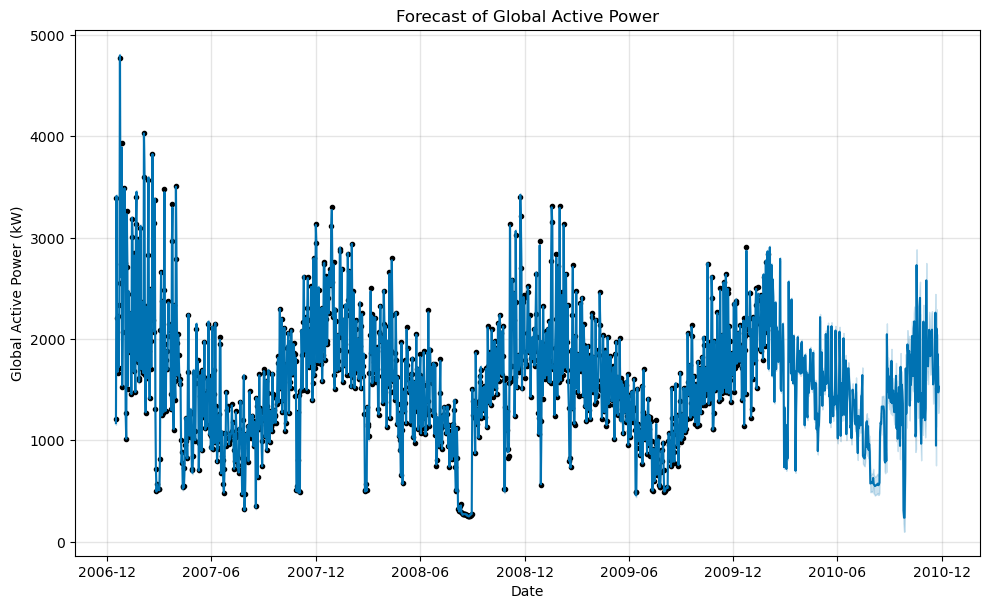

In [21]:
# Plot the forecast
fig = model.plot(forecast)
plt.title('Forecast of Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.show()

In [22]:
# Evaluate the model on the test set
forecast_test = forecast.iloc[-300:][['ds', 'yhat']]
forecast_test = forecast_test.set_index('ds')
test_df.set_index('ds', inplace=True)

### Q17
Evaluating the results of your time series modeling on the test set, what is the MAPE (in %) in 2 decimal places?

### Q18
What is the RMSE in 2 decimal places?

In [23]:
mae = mean_absolute_error(test_df['y'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(test_df['y'], forecast_test['yhat']))
mape = mean_absolute_percentage_error(test_df['y'], forecast_test['yhat'])

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute  Percentage Error (MAE): {mape*100:.2f}')

Mean Absolute Error (MAE): 30.346890248688343
Root Mean Squared Error (RMSE): 33.26
Mean Absolute  Percentage Error (MAE): 2.44


### Q19
If you plot the components from the multivariate forecasted model, what day of the daily seasonality has the lowest value?

### Q20
If you plot the components from the forecasted model, what month of the yearly seasonality has the lowest value?

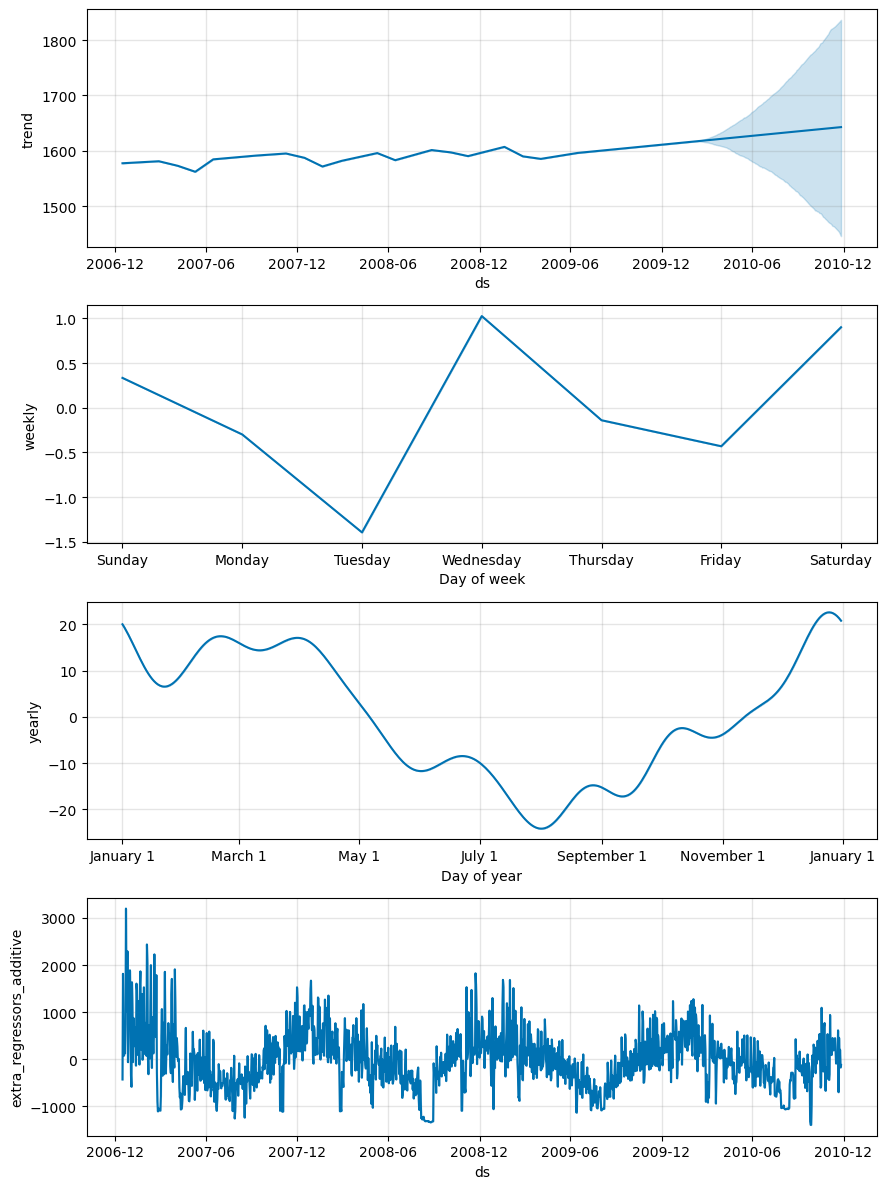

In [24]:
model.plot_components(forecast)
plt.show()